In [1]:
%matplotlib inline
#%matplotlib qt
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import pylab as plt
import root_numpy
import pandas as pd
import numpy
from scipy.stats import gaussian_kde
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


BRICK_X = 124000
# Changed due to ignorance of 57th layer. Originally : #BRICK_Y = 99000
BRICK_Y = 76710
BRICK_Z = 75000
SAFE_M = 10000
dZ = 205

import numpy.linalg as la
 
def angle(v1, v2):
    cos = (v1*v2).sum(axis=1)
    sin = la.norm(numpy.cross(v1, v2, axis=1), axis=1)
    return numpy.arctan2(sin, cos)

In [2]:
def load_bg(step=1000):
    # ignore 57th layer since it looks different
    etalon_plates = []
    for p in range(48, 57):
        backtracks = root_numpy.root2array("data-2016/129294.{p}.1.1000.cp.root".format(p=p), 
                                       treename="couples", 
                                       branches=["s.eX", "s.eY", "s.eZ",
                                                "s.eTX", "s.eTY",
                                                "s.eChi2"], step=step)
        etalon_plates.append(backtracks)
        
    df = None
    for p in range(58):
        plate = numpy.copy(etalon_plates[p % len(etalon_plates)])
        plate['s.eZ'] = p * 1293
        # plt.hist(backtracks['s.eY'], bins=100, histtype='step', label="%d"%p)
        if df is None:
            df = pd.DataFrame(plate)
            # print ">", df.shape
        else:
            df = pd.concat([df, pd.DataFrame(plate)], ignore_index=True)
    # plt.legend()
    print ("bg: {n} tracks".format(n=df.shape[0]))
    return df

In [3]:
def load_mc(filename="data-2016/mcdata_taue2.root", step=1):
    mc = root_numpy.root2array(
                        filename,
                        treename="Data",
                        branches=["Event_id", "ele_P",
                                   "BT_X", "BT_Y", "BT_Z",
                                   "BT_SX", "BT_SY",
                                   "ele_x", "ele_y", "ele_z", 
                                   "ele_sx", "ele_sy", 
                                   "chisquare"],
                        step=step)
    pmc = pd.DataFrame(mc)
    pmc['numtracks'] = pmc.BT_X.apply(lambda x: len(x))
    # cuts
    shapechange = [pmc.shape[0]]
    pmc = pmc[pmc.ele_P > 0.1]
    shapechange.append(pmc.shape[0])
    
    #pmc = pmc[pmc.ele_x.abs() < BRICK_X / 2 - SAFE_M]
    #shapechange.append(pmc.shape[0])
    ele_x = numpy.random.uniform(BRICK_X / 2 - SAFE_M, BRICK_X / 2 + SAFE_M, size=pmc.shape[0])
    delta_ele_x = pmc.ele_x - ele_x
    pmc.ele_x = ele_x
    pmc.BT_X -= delta_ele_x
    
    #pmc = pmc[pmc.ele_y.abs() < BRICK_Y / 2 - SAFE_M]
    #shapechange.append(pmc.shape[0])
    ele_y = numpy.random.uniform(BRICK_Y / 2 - SAFE_M, BRICK_Y / 2 + SAFE_M, size=pmc.shape[0])
    delta_ele_y = pmc.ele_y - ele_y
    pmc.ele_y = ele_y
    pmc.BT_Y -= delta_ele_y
    
    pmc = pmc[pmc.ele_z < 0]
    shapechange.append(pmc.shape[0])
    
    pmc = pmc[pmc.numtracks > 3]
    shapechange.append(pmc.shape[0])
    print ("numtracks reduction by cuts: ", shapechange)
    # calc centers
    # to brick reference frame and center
    pmc['m_BT_X'] = pmc.BT_X.apply(lambda x: x.mean())
    pmc['m_BT_Y'] = pmc.BT_Y.apply(lambda x: x.mean())
    pmc['m_BT_Z'] = pmc.BT_Z.apply(lambda x: x.mean())
    #pmc.BT_X += BRICK_X / 2
    #pmc.BT_Y += BRICK_Y / 2
    pmc.BT_Z += BRICK_Z / 2
    #pmc.ele_x += BRICK_X / 2
    #pmc.ele_y += BRICK_Y / 2
    pmc.ele_z += BRICK_Z / 2
    print ("len(pmc): {len}".format(len=len(pmc)))
    return pmc

In [4]:
pbg = load_bg(step=1)

TClass::TClass:0: RuntimeWarning: no dictionary for class EdbPoint2D is available
TClass::TClass:0: RuntimeWarning: no dictionary for class EdbPoint is available
TClass::TClass:0: RuntimeWarning: no dictionary for class EdbTrack2D is available
TClass::TClass:0: RuntimeWarning: no dictionary for class EdbAngle2D is available
TClass::TClass:0: RuntimeWarning: no dictionary for class EdbSegCouple is available
TClass::TClass:0: RuntimeWarning: no dictionary for class EdbSegP is available
TClass::TClass:0: RuntimeWarning: no dictionary for class EdbID is available


bg: 27322110 tracks


In [5]:
pmc = load_mc(step=1)

numtracks reduction by cuts:  [18724, 18679, 9616, 9106]
len(pmc): 9106


In [6]:
BT_Z_unique = numpy.unique(pbg['s.eZ'])
bg_density = len(pbg)/((pbg['s.eZ'].max() - pbg['s.eZ'].min())*
                       (pbg['s.eY'].max() - pbg['s.eY'].min())*
                       (pbg['s.eX'].max() - pbg['s.eX'].min()))

In [7]:
print (len(pbg))

27322110


In [8]:
res_angle = []
for id in range(len(pmc)):
    df = pmc.iloc[id]   
    dmc = pd.DataFrame([        
                df['BT_X'],
                df['BT_Y'],
                df['BT_Z'],
                df['BT_SX'],
                df['BT_SY'],
                df['BT_X'] + df['BT_SX']*dZ,
                df['BT_Y'] + df['BT_SY']*dZ,
                df['BT_Z'] + dZ,
                df['chisquare'][:len(df['BT_X'])]],
                index=['sx', 'sy', 'sz', 'TX', 'TY', 
              'ex', 'ey', 'ez', 'chi2']).T    
    dd = dmc
    dd['ele_x'] = df['ele_x']
    dd['ele_y'] = df['ele_y']
    dd['ele_z'] = df['ele_z']
    dd['ele_sx'] = df['ele_sx']
    dd['ele_sy'] = df['ele_sy']
    dd['ele_sz'] = 1
    alpha = angle(numpy.array([(dd['sx'] - dd['ele_x']), (dd['sy'] - dd['ele_y']), (dd['sz'] - dd['ele_z'])]).T, 
                  numpy.array([dd['ele_sx'], dd['ele_sy'], dd['ele_sz']]).T)
    res_angle += alpha.tolist()
    if id % 100 == 0:
        print (id, end=' ')

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 

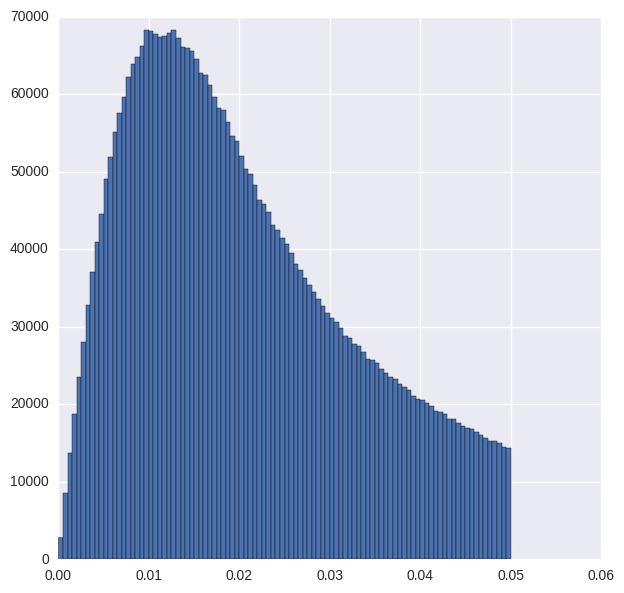

In [9]:
plt.figure(figsize=(7,7));
plt.hist(res_angle, range=(0,0.05), bins=100);

In [10]:
def plot_bg_and_mc(pbg, pmc, id=1, step=1):
    df = pbg.sample(n=27000)
    # mind the order!
    d0 = pd.DataFrame([
                df['s.eZ'][::step],
                df['s.eX'][::step],
                df['s.eY'][::step]],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['s.eTX'][::step]*dZ,
            df['s.eTY'][::step]*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    # print d0, d1
    C = plt.cm.Blues(0.5)
    lc_bg = Line3DCollection(list(zip(d0.values, d1.values)), colors=C, alpha=0.5, lw=2)
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-84, elev=10)
    df = pmc.iloc[id]
    # mind the order!
    d0 = pd.DataFrame([
                df['BT_Z'],
                df['BT_X'],
                df['BT_Y']],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['BT_SX']*dZ,
            df['BT_SY']*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    #print (d0, d1)
    C = plt.cm.Reds(0.5)
    lc_mc = Line3DCollection(list(zip(d0.values, d1.values)), colors=C, alpha=0.9, lw=2)

    ax.add_collection3d(lc_mc)
    ax.add_collection3d(lc_bg)
    # mind the order!
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")  
    ax.set_xlim(0, BRICK_Z)
    ax.set_ylim(0, BRICK_X)
    ax.set_zlim(0, BRICK_Y)

In [11]:
def combine_mc_bg(pmc, pbg, id=0):
    dZ = 204
    #random permutation of basetracks in background
    #pbg['s.eX'] = pbg['s.eX'].sample(frac=1)
    #pbg['s.eY'] = pbg['s.eY'].sample(frac=1)
    #pbg['s.eZ'] = pbg['s.eZ'].sample(frac=1)
    
    df = pmc.iloc[id]
    Delta_Z = (BT_Z_unique.max() - df.ele_z)
    Max_X = df.ele_x + min((max(df.ele_sx, 0) + 0.11)*Delta_Z, 72240.312500)
    Min_X = df.ele_x - max((min(df.ele_sx, 0) - 0.11)*Delta_Z, 27762.396484)
    Max_Y = df.ele_y + min((max(df.ele_sy, 0) + 0.11)*Delta_Z, 76710.242188)
    Min_Y = df.ele_y - max((min(df.ele_sy, 0) - 0.11)*Delta_Z, 3312.499512)
    Delta_X = (abs(df.ele_sx) + 0.11)*Delta_Z
    Delta_Y = (abs(df.ele_sy) + 0.11)*Delta_Z
    
    #N = int(Delta_Z*Delta_Y*Delta_X*4*bg_density)
    N = int(Delta_Z*(Max_X - Min_X)*(Max_Y - Min_Y)*bg_density)
    pbg = pbg.sample(n = N)
    pbg['s.eZ'] = numpy.random.choice(BT_Z_unique[BT_Z_unique >= df.ele_z], size=N)
    pbg['s.eX'] = numpy.random.uniform(low = Min_X,
                                       high = Max_X,
                                       size = N)
    pbg['s.eY'] = numpy.random.uniform(low = Min_Y,
                                       high = Max_Y,
                                       size = N)    
    dmix = pd.DataFrame([
                pbg['s.eX'],
                pbg['s.eY'],
                pbg['s.eZ'],
                pbg['s.eTX'],
                pbg['s.eTY'],
                pbg['s.eX'] + pbg['s.eTX']*dZ,
                pbg['s.eY'] + pbg['s.eTY']*dZ,
                pbg['s.eZ'] + dZ,
                pbg['s.eChi2']],
                index=['sx', 'sy', 'sz', 'TX', 'TY', 
                       'ex', 'ey', 'ez', 'chi2']).T
    #d0['signal'] = 0
    dmix['signal'] = 0
       
    dmc = pd.DataFrame([        
                df['BT_X'],
                df['BT_Y'],
                df['BT_Z'],
                df['BT_SX'],
                df['BT_SY'],
                df['BT_X'] + df['BT_SX']*dZ,
                df['BT_Y'] + df['BT_SY']*dZ,
                df['BT_Z'] + dZ,
                df['chisquare'][:len(df['BT_X'])]],
                index=['sx', 'sy', 'sz', 'TX', 'TY', 
              'ex', 'ey', 'ez', 'chi2']).T
    dmc['signal'] = 1
    
    dd = pd.concat([dmix, dmc])
    dd['ele_x'] = df['ele_x']
    dd['ele_y'] = df['ele_y']
    dd['ele_z'] = df['ele_z']
    dd['ele_sx'] = df['ele_sx']
    dd['ele_sy'] = df['ele_sy']
    dd['ele_sz'] = 1
    alpha = angle(numpy.array([(dd['sx'] - dd['ele_x']), (dd['sy'] - dd['ele_y']), (dd['sz'] - dd['ele_z'])]).T, 
                  numpy.array([dd['ele_sx'], dd['ele_sy'], dd['ele_sz']]).T)
    dd['alpha'] = alpha
    dd = dd.loc[dd.chi2 < 3]
    dd = dd.loc[dd.alpha < 0.05]
    return dd

# Хафа преобразование

Так как углы наклона base-track известны, то понятно, что можно просто перевести весь массив base-track'ов в параметрическое пространство(5 параметров: направляющий вектор + x, y, вид параметризации взят из https://lionel.kr.hs-niederrhein.de/~dalitz/data/publications/hough3d-visapp16.pdf ).
А дальше можно просто либо гистограмму, либо с помощью gaussian_kde оценить плотность распределения.

Прямого применения для нахождения вершины и направления она не нашла, но, зато, значение плотности распределения используется как ещё одна переменная.

In [12]:
def cartesian_to_spherical(x,y,z):
    r_xy = x**2 + y**2
    r = numpy.sqrt(r_xy + z**2)
    theta = numpy.arctan2(z, numpy.sqrt(r_xy))
    phi = numpy.arctan2(y, x)
    return numpy.array([numpy.cos(phi)*numpy.cos(theta), numpy.sin(phi)*numpy.cos(theta), numpy.sin(theta)])

def Simple_Hough3D(sx, sy, sz, ex, ey):
    B = cartesian_to_spherical(ex - sx, ey - sy, 205)
    X = (1 - B[0]**2/(1 + B[2])) * sx - B[0] * B[1] / (1 + B[2]) * sy - B[0] * sz
    Y = - B[0] * B[1] / (1 + B[2]) * sx + (1 - B[1]**2/(1 + B[2])) * sy - B[1] * sz
    return B, X.reshape((1,-1)), Y.reshape((1,-1))

In [15]:
num_idx = 200
train = pd.DataFrame()
for id in numpy.arange(0, num_idx):
    train_tmp = combine_mc_bg(pmc, pbg, id=id)
    
    print ('Lost basetracks:', 1 - sum(train_tmp.signal)/pmc.iloc[id].numtracks, '%')
    #B, X, Y = Simple_Hough3D(train_tmp.sx.values, train_tmp.sy.values, train_tmp.sz.values, train_tmp.ex.values, train_tmp.ey.values)
    #kernel_train = gaussian_kde(numpy.concatenate([B, X, Y]))
    #density_train = kernel_train(numpy.concatenate([B, X, Y]))
    
    print (sum(train_tmp.signal))
    #train_tmp['pdf_density'] = density_train
    train_tmp['group'] = id
    train = train.append(train_tmp)

Lost basetracks: 0.262554585153 %
2702
Lost basetracks: 0.1875 %
13
Lost basetracks: 0.268138801262 %
232
Lost basetracks: 0.282894736842 %
109
Lost basetracks: 0.248076923077 %
391
Lost basetracks: 0.218487394958 %
93
Lost basetracks: 0.419047619048 %
61
Lost basetracks: 0.19512195122 %
495
Lost basetracks: 0.541666666667 %
11
Lost basetracks: 0.254278728606 %
305
Lost basetracks: 0.402597402597 %
46
Lost basetracks: 0.252631578947 %
213
Lost basetracks: 0.411042944785 %
96
Lost basetracks: 0.390804597701 %
53
Lost basetracks: 0.246453900709 %
425
Lost basetracks: 0.186411149826 %
467
Lost basetracks: 0.259842519685 %
94
Lost basetracks: 0.215517241379 %
1183
Lost basetracks: 0.199191102123 %
792
Lost basetracks: 0.583333333333 %
60
Lost basetracks: 0.264804469274 %
658
Lost basetracks: 0.336734693878 %
195
Lost basetracks: 0.358208955224 %
86
Lost basetracks: 0.995620437956 %
3
Lost basetracks: 0.703703703704 %
8
Lost basetracks: 0.246753246753 %
406
Lost basetracks: 0.219455252918 %

In [16]:
test = pd.DataFrame()
for id in numpy.arange(201, 301):
    test_tmp = combine_mc_bg(pmc, pbg, id=id)

    print ('Lost basetracks:', 1 - sum(test_tmp.signal)/pmc.iloc[id].numtracks, '%')
    #B, X, Y = Simple_Hough3D(test_tmp.sx.values, test_tmp.sy.values, test_tmp.sz.values, test_tmp.ex.values, test_tmp.ey.values)
    #kernel_train = gaussian_kde(numpy.concatenate([B, X, Y]))
    #density_train = kernel_train(numpy.concatenate([B, X, Y]))
    print (sum(test_tmp.signal))
    #test_tmp['pdf_density'] = density_train
    
    test_tmp['group'] = id
    test = test.append(test_tmp)

Lost basetracks: 0.75 %
61
Lost basetracks: 0.388571428571 %
107
Lost basetracks: 0.258278145695 %
1120
Lost basetracks: 0.135550935551 %
2079
Lost basetracks: 0.248882265276 %
1008
Lost basetracks: 0.131386861314 %
238
Lost basetracks: 0.375 %
130
Lost basetracks: 0.469879518072 %
132
Lost basetracks: 0.192307692308 %
42
Lost basetracks: 0.577319587629 %
41
Lost basetracks: 0.234413965087 %
307
Lost basetracks: 0.232876712329 %
168
Lost basetracks: 0.233128834356 %
125
Lost basetracks: 0.279661016949 %
510
Lost basetracks: 0.289473684211 %
108
Lost basetracks: 0.285714285714 %
5
Lost basetracks: 0.331877729258 %
306
Lost basetracks: 0.153727901614 %
3303
Lost basetracks: 0.441558441558 %
129
Lost basetracks: 0.164583333333 %
401
Lost basetracks: 0.441330998249 %
319
Lost basetracks: 0.470588235294 %
9
Lost basetracks: 0.268518518519 %
316
Lost basetracks: 0.126227208976 %
623
Lost basetracks: 0.132258064516 %
538
Lost basetracks: 0.228828828829 %
428
Lost basetracks: 0.269230769231 %


In [19]:
train['X_proj'] = train['sx'] - train['TX']*(train['sz'] - train['ele_z'])
train['Y_proj'] = train['sy'] - train['TY']*(train['sz'] - train['ele_z'])

train['IP/dZ'] = numpy.sqrt((train['ele_x'] - train['X_proj'])**2 + (train['ele_y'] - train['Y_proj'])**2)/(train['sz'] - train['ele_z'])

train['TX'] = train['TX'] - train['ele_sx']
train['TY'] = train['TY'] - train['ele_sy']

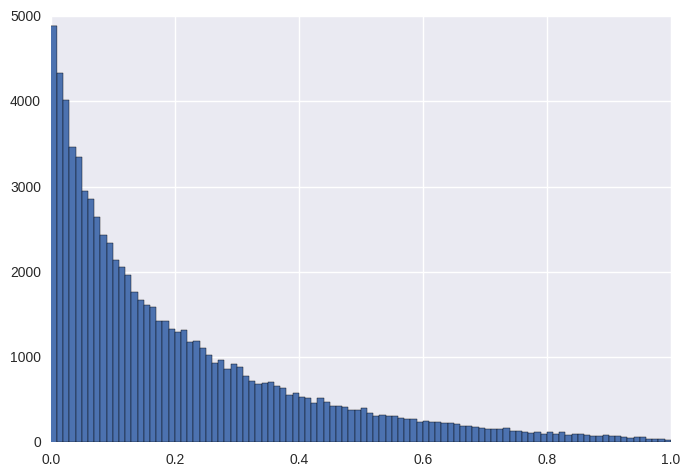

In [36]:
plt.hist(train.loc[(train.signal == 1)]['IP/dZ'], bins=100, range=(0,1));

In [37]:
test['X_proj'] = test['sx'] - test['TX']*(test['sz'] - test['ele_z'])
test['Y_proj'] = test['sy'] - test['TY']*(test['sz'] - test['ele_z'])

test['IP/dZ'] = numpy.sqrt((test['ele_x'] - test['X_proj'])**2 + (test['ele_y'] - test['Y_proj'])**2)/(test['sz'] - test['ele_z'])

test['TX'] = test['TX'] - test['ele_sx']
test['TY'] = test['TY'] - test['ele_sy']

In [38]:
features = list(set(train.columns) - {'signal', 'sx', 'sx', 'sy', 'sz', 'ex', 'ey', 'ez', 'X_proj', 'Y_proj',
                                     'ele_x', 'ele_y', 'ele_z', 'ele_sx', 'ele_sy', 'group','pdf_density','ele_sz'})

In [39]:
features

['TX', 'alpha', 'IP/dZ', 'TY', 'chi2']

In [40]:
%%time
params = {'max_depth' : [8],
          'n_estimators' : [150],
           'min_child_weight':[1],
           'subsample':[0.8], 
           'colsample_bytree':[0.8]}

clf = GridSearchCV(XGBClassifier(silent=False, learning_rate=0.1), params, scoring='roc_auc', cv=3, refit=True)
clf.fit(train[features], train.signal, groups=train.group);

CPU times: user 1h 22min 38s, sys: 1min 54s, total: 1h 24min 33s
Wall time: 20min 54s


In [41]:
clf.grid_scores_

/home/acapello/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.95929, std: 0.00220, params: {'min_child_weight': 1, 'max_depth': 8, 'colsample_bytree': 0.8, 'n_estimators': 150, 'subsample': 0.8}]

In [42]:
from sklearn.metrics import roc_curve, auc
y_score = clf.predict_proba(test[features])
fpr, tpr, _ = roc_curve(test.signal.values, y_score[:, 1], drop_intermediate=True)
roc_auc = auc(fpr, tpr)
print ('RO C AUC =', roc_auc)
print ("False positive rate =",fpr[tpr > .5][0], "while True positive = 0.5")
print ("True positive rate = ", tpr[fpr == 0.][-1], ", while False postive rate = 0.0")
print ()

RO C AUC = 0.96198414298
False positive rate = 0.00429521639451 while True positive = 0.5
True positive rate =  0.0137648905241 , while False postive rate = 0.0



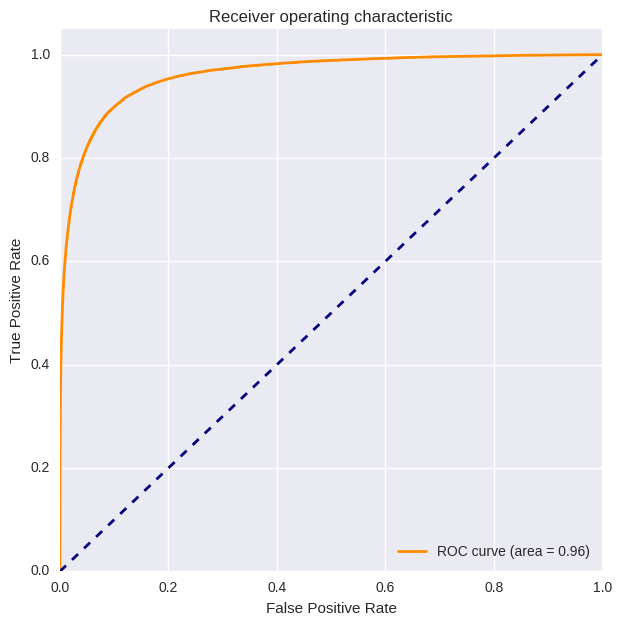

In [43]:
y_score = clf.predict_proba(test[features])

fpr, tpr, _ = roc_curve(test.signal.values, y_score[:, 1], drop_intermediate=True)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Часть 2

In [44]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

def metric_res(u, v):
    X = numpy.array([[u[0], u[0] + u[3]*dZ, v[0], v[0] + v[3]*dZ], 
                     [u[1], u[1] + u[4]*dZ, v[1], v[1] + v[4]*dZ],
                     [u[2], u[2] + dZ, v[2], v[2] + dZ]]).T
    pca = PCA(n_components=1).fit(X)
    t = ((X - pca.mean_)/pca.components_).mean(axis=1)
    res = (X - pca.mean_) - pca.components_*t[:,numpy.newaxis]
    residual = numpy.sqrt(((res**2).sum(axis=1)).sum())
    return residual

def metric_angle(u, v):
    alpha_1 = angle(numpy.array([[u[3], u[4], 1]]), 
                    numpy.array([[v[0] - u[0], v[1] - u[1], v[2] - u[2]]]))
    alpha_2 = angle(numpy.array([[u[3], u[4], 1]]), 
                    numpy.array([[v[0] + dZ*v[3] - u[0], v[1] + dZ*v[4] - u[1], v[2] + dZ - u[2]]]))
    alpha_3 = angle(numpy.array([[v[3], v[4], 1]]), 
                    numpy.array([[v[0] + dZ*v[3] - u[0], v[1] + dZ*v[4] - u[1], v[2] + dZ - u[2]]]))
    alpha_4 = angle(numpy.array([[v[3], v[4], 1]]), 
                    numpy.array([[v[0] + dZ*v[3] - u[0] - dZ*u[3], v[1] + dZ*v[4] - u[1] - dZ*u[4], v[2]  - u[2]]]))
    alpha_1 = min(alpha_1, numpy.pi - alpha_1)
    alpha_2 = min(alpha_2, numpy.pi - alpha_2)
    alpha_3 = min(alpha_3, numpy.pi - alpha_3)
    alpha_4 = min(alpha_4, numpy.pi - alpha_4)
    return alpha_1 + alpha_2 + alpha_3 + alpha_4

In [45]:
def combine_mc_bg(pmc, pbg, id=0):
    dZ = 204
    #random permutation of basetracks in background
    #pbg['s.eX'] = pbg['s.eX'].sample(frac=1)
    #pbg['s.eY'] = pbg['s.eY'].sample(frac=1)
    #pbg['s.eZ'] = pbg['s.eZ'].sample(frac=1)
    df = pmc.iloc[id]
    frac_z = (BT_Z_unique.max() - df.ele_z)/(BT_Z_unique.max() - BT_Z_unique.min())
    pbg = pbg.sample(frac=frac_z)
    pbg['s.eZ'] = numpy.random.choice(BT_Z_unique[BT_Z_unique >= df.ele_z], size=len(pbg)) 
    dmix = pd.DataFrame([
                pbg['s.eX'],
                pbg['s.eY'],
                pbg['s.eZ'],
                pbg['s.eTX'],
                pbg['s.eTY'],
                pbg['s.eX'] + pbg['s.eTX']*dZ,
                pbg['s.eY'] + pbg['s.eTY']*dZ,
                pbg['s.eZ'] + dZ,
                pbg['s.eChi2']],
                index=['sx', 'sy', 'sz', 'TX', 'TY', 
                       'ex', 'ey', 'ez', 'chi2']).T
    dmix['signal'] = 0
       
    dmc = pd.DataFrame([        
                df['BT_X'],
                df['BT_Y'],
                df['BT_Z'],
                df['BT_SX'],
                df['BT_SY'],
                df['BT_X'] + df['BT_SX']*dZ,
                df['BT_Y'] + df['BT_SY']*dZ,
                df['BT_Z'] + dZ,
                df['chisquare'][:len(df['BT_X'])]],
                index=['sx', 'sy', 'sz', 'TX', 'TY', 
              'ex', 'ey', 'ez', 'chi2']).T
    dmc['signal'] = 1
    
    dd = pd.concat([dmix, dmc])
    dd['ele_x'] = df['ele_x']
    dd['ele_y'] = df['ele_y']
    dd['ele_z'] = df['ele_z']
    dd['ele_sx'] = df['ele_sx']
    dd['ele_sy'] = df['ele_sy']
    dd['ele_sz'] = 1
    alpha = angle(numpy.array([(dd['sx'] - dd['ele_x']), (dd['sy'] - dd['ele_y']), (dd['sz'] - dd['ele_z'])]).T, 
                  numpy.array([dd['ele_sx'], dd['ele_sy'], dd['ele_sz']]).T)
    dd['alpha'] = alpha
    dd = dd.loc[dd.chi2 < 3]
    return dd

In [46]:
pbg = load_bg(step=100)
train = combine_mc_bg(pmc, pbg, id=0)

bg: 273237 tracks


In [47]:
len(train)

237777

In [48]:
low = 68529.0
mid = 69822.0
high = 71115.0

right_layer = train.loc[(train.sz >= mid) & (train.sz < high)][['sx', 'sy', 'sz', 'TX', 'TY', 'signal']]
left_layer = train.loc[(train.sz < mid) & (train.sz >= low)][['sx', 'sy', 'sz', 'TX', 'TY', 'signal']]

In [49]:
print (len(right_layer))
print (len(left_layer))

4969
5017


In [51]:
%%time
nn = NearestNeighbors(metric=metric_angle, n_jobs=8, algorithm='brute').fit(right_layer)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 628 µs


In [52]:
%%time
A,B = nn.kneighbors(left_layer, 2)

CPU times: user 5.08 s, sys: 1.6 s, total: 6.68 s
Wall time: 21min 13s


In [53]:
right_layer_selected = right_layer.iloc[B[:, 0]]

In [54]:
def pca_axis(a):
    X = numpy.array([[a[0], a[0] + a[3]*dZ, a[6], a[6] + a[9]*dZ], 
                     [a[1], a[1] + a[4]*dZ, a[7], a[7] + a[10]*dZ],
                     [a[2], a[2] + dZ, a[8], a[8] + dZ]]).T
    pca = PCA(n_components=1).fit(X)
    t = ((X - pca.mean_)/pca.components_).mean(axis=1)
    res = (X - pca.mean_) - pca.components_*t[:,numpy.newaxis]
    residual = numpy.sqrt(((res**2).sum(axis=1)).sum())
    return residual
def alpha_axis(a):
    alpha_1 = angle(numpy.array([[a[3], a[4], 1]]), 
                    numpy.array([[a[6] - a[0], a[7] - a[1], a[8] - a[2]]]))
    alpha_2 = angle(numpy.array([[a[3], a[4], 1]]), 
                    numpy.array([[a[6] + dZ*a[9] - a[0], a[7] + dZ*a[10] - a[1], a[8] + dZ - a[2]]]))
    alpha_3 = angle(numpy.array([[a[9], a[10], 1]]), 
                    numpy.array([[a[6] + dZ*a[9] - a[0], a[7] + dZ*a[10] - a[1], a[8] + dZ - a[2]]]))
    alpha_4 = angle(numpy.array([[a[9], a[10], 1]]), 
                    numpy.array([[a[6] + dZ*a[9] - a[0] - dZ*a[3], a[7] + dZ*a[10] - a[1] - dZ*a[4], a[8]  - a[2]]]))
    alpha_1 = min(alpha_1, numpy.pi - alpha_1)
    alpha_2 = min(alpha_2, numpy.pi - alpha_2)
    alpha_3 = min(alpha_3, numpy.pi - alpha_3)
    alpha_4 = min(alpha_4, numpy.pi - alpha_4)
    return alpha_1 + alpha_2 + alpha_3 + alpha_4

In [55]:
%%time
tmp = numpy.concatenate((left_layer.values, right_layer_selected.values), axis=1)
res_axis = numpy.apply_along_axis(pca_axis, 1, tmp)

CPU times: user 1.35 s, sys: 52 ms, total: 1.4 s
Wall time: 1.35 s


In [56]:
%%time
tmp = numpy.concatenate((left_layer.values, right_layer_selected.values), axis=1)
alpha_axis = numpy.apply_along_axis(alpha_axis, 1, tmp)

CPU times: user 1.03 s, sys: 48 ms, total: 1.08 s
Wall time: 1 s


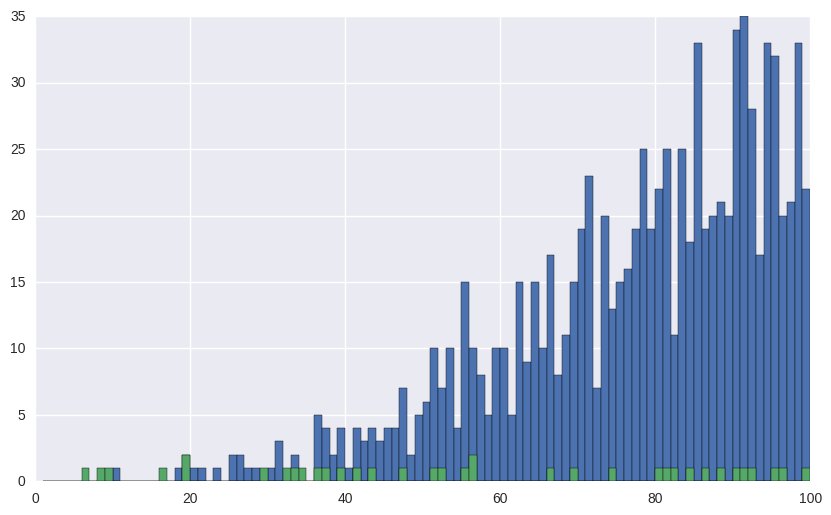

In [57]:
plt.figure(figsize=(10,6))
plt.hist(res_axis[(left_layer.signal == 0).values], bins=100, range=(0,100));
plt.hist(res_axis[(left_layer.signal == 1).values], bins=100, range=(0,100));

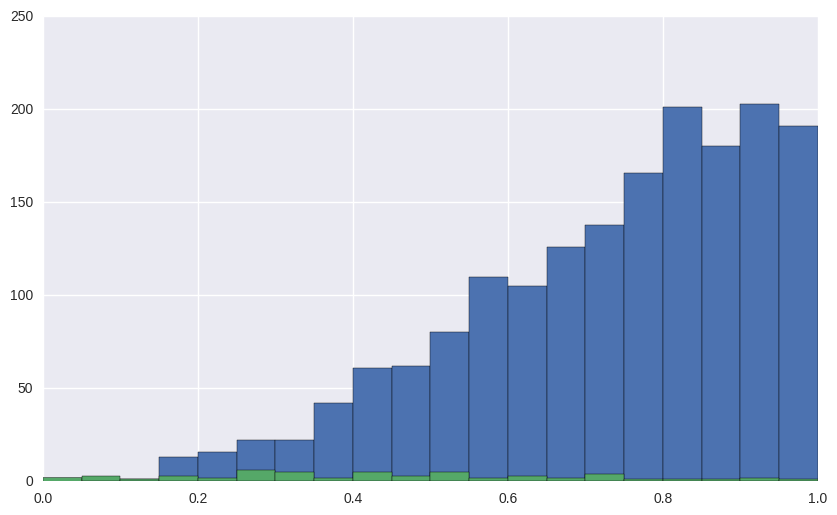

In [58]:
plt.figure(figsize=(10,6))
plt.hist(alpha_axis[(left_layer.signal == 0).values], bins=20, range=(0,1));
plt.hist(alpha_axis[(left_layer.signal == 1).values], bins=20, range=(0,1));